In [1]:
pip install tqdm


In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
from google.colab import drive
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Function to check if the file exists
def is_valid_file(path):
    return os.path.exists(path)

In [6]:
# Define transforms for the training, validation, and testing data
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Define the data directory paths
train_dir = '/content/drive/My Drive/full_db/Train_final'
val_dir = '/content/drive/My Drive/full_db/Val_final'
test_dir = '/content/drive/My Drive/full_db/Test_final'

In [8]:
# Load the datasets with ImageFolder using is_valid_file to filter out missing files
train_data = datasets.ImageFolder(train_dir, transform=train_transforms, is_valid_file=is_valid_file)
val_data = datasets.ImageFolder(val_dir, transform=val_transforms, is_valid_file=is_valid_file)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms, is_valid_file=is_valid_file)


In [9]:
# Define the dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)


In [10]:
# Define a function to find the number of features in the final layer
def get_num_features(model, input_size):
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, input_size, input_size)
        features = model.forward_features(dummy_input)
        num_features = features.shape[1]
    return num_features

In [11]:
# Define the CNN architecture using MobileViT
class PlantCNN(nn.Module):
    def __init__(self, num_classes, input_size=256):
        super(PlantCNN, self).__init__()
        self.model = create_model('mobilevit_s', pretrained=True)
        num_features = get_num_features(self.model, input_size)
        # Replace the final layer
        self.model.head = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.model.head(x)
        return x

In [12]:
# Initialize the model, loss function, and optimizer
num_classes = len(train_data.classes)
model = PlantCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

In [13]:
# Train the model with early stopping and record accuracy/loss
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Add tqdm progress bar for training
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_tqdm:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm description with current loss and accuracy
            train_loader_tqdm.set_postfix(loss=running_loss/total, accuracy=100. * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, plot_cm=False)  # Disable plotting CM during validation
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_acc:.2f}%")

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'MobileVit_model.pth')  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

In [15]:
# Evaluate the model and generate confusion matrix
def evaluate_model(model, data_loader, criterion, plot_cm=True):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    all_labels = []
    all_predictions = []

    # Add tqdm progress bar for evaluation
    data_loader_tqdm = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for inputs, labels in data_loader_tqdm:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    eval_loss /= len(data_loader)
    eval_acc = 100 * correct / total

    if plot_cm:
        plot_confusion_matrix(all_labels, all_predictions, train_data.classes)

    return eval_loss, eval_acc, all_labels, all_predictions

In [16]:
# Plot training and validation accuracy/loss
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [17]:
# Plot confusion matrix
def plot_confusion_matrix(all_labels, all_predictions, classes):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Evaluating: 100%|██████████| 61/61 [21:12<00:00, 20.86s/batch]


Epoch [1/10], Loss: 0.258196, Accuracy: 94.05%
Validation Loss: 0.071420, Validation Accuracy: 97.85%


Evaluating: 100%|██████████| 61/61 [04:19<00:00,  4.26s/batch]


Epoch [2/10], Loss: 0.053600, Accuracy: 98.37%
Validation Loss: 0.051181, Validation Accuracy: 98.36%


Evaluating: 100%|██████████| 61/61 [04:20<00:00,  4.26s/batch]


Epoch [3/10], Loss: 0.041706, Accuracy: 98.65%
Validation Loss: 0.058849, Validation Accuracy: 97.92%


Evaluating: 100%|██████████| 61/61 [04:35<00:00,  4.52s/batch]


Epoch [4/10], Loss: 0.027717, Accuracy: 99.20%
Validation Loss: 0.124031, Validation Accuracy: 95.85%


Evaluating: 100%|██████████| 61/61 [04:22<00:00,  4.30s/batch]


Epoch [5/10], Loss: 0.030515, Accuracy: 99.07%
Validation Loss: 0.015922, Validation Accuracy: 99.59%


Evaluating: 100%|██████████| 61/61 [04:12<00:00,  4.15s/batch]


Epoch [6/10], Loss: 0.023767, Accuracy: 99.25%
Validation Loss: 0.055878, Validation Accuracy: 98.05%


Evaluating: 100%|██████████| 61/61 [04:13<00:00,  4.15s/batch]


Epoch [7/10], Loss: 0.026243, Accuracy: 99.17%
Validation Loss: 0.099095, Validation Accuracy: 97.15%


Evaluating: 100%|██████████| 61/61 [04:07<00:00,  4.06s/batch]


Epoch [8/10], Loss: 0.022552, Accuracy: 99.32%
Validation Loss: 0.022084, Validation Accuracy: 99.23%
Early stopping triggered


Evaluating: 100%|██████████| 61/61 [21:38<00:00, 21.29s/batch]


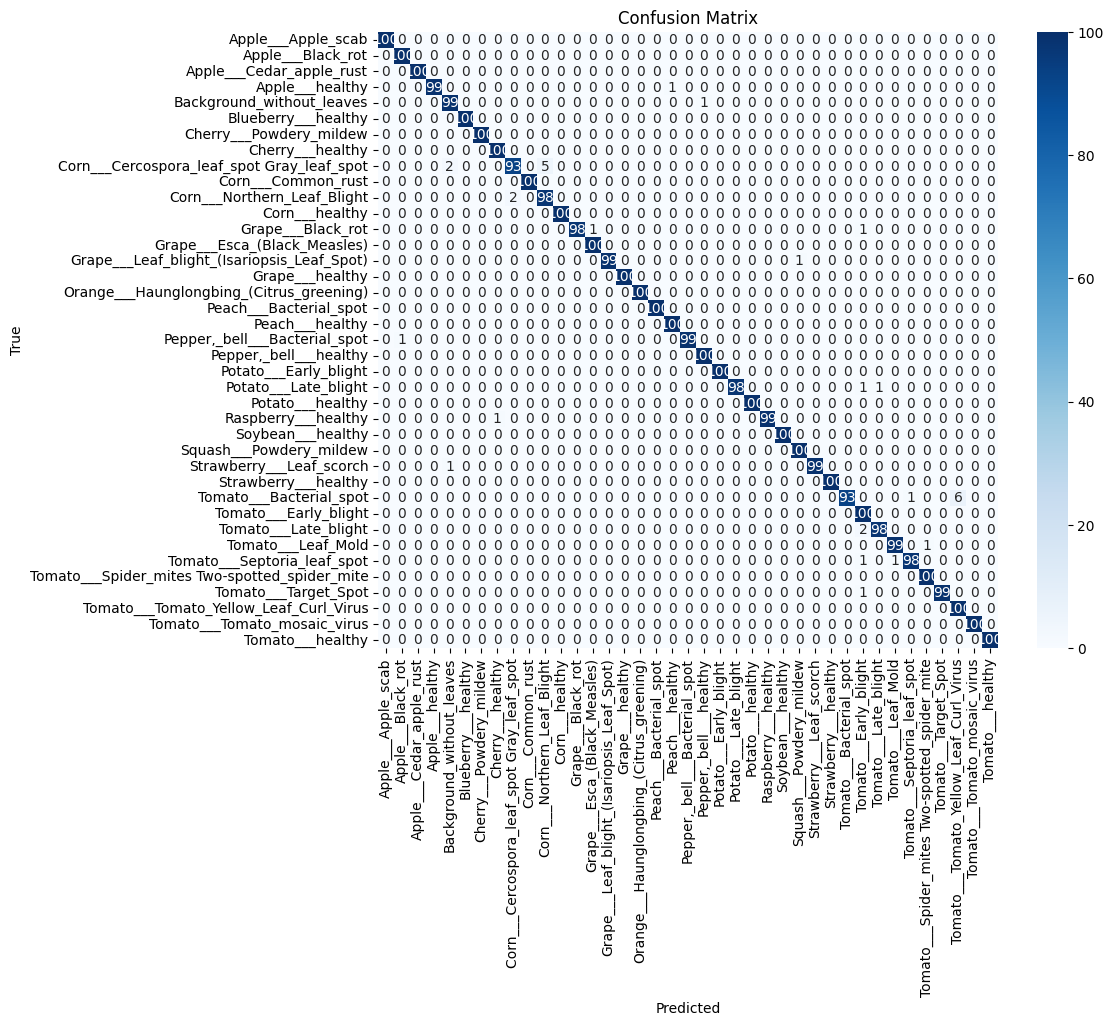

Test Loss: 0.024483, Test Accuracy: 99.18%


In [18]:
# Run the training and evaluation
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)
model.load_state_dict(torch.load('MobileVit_model.pth'))  # Load the best model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.2f}%")

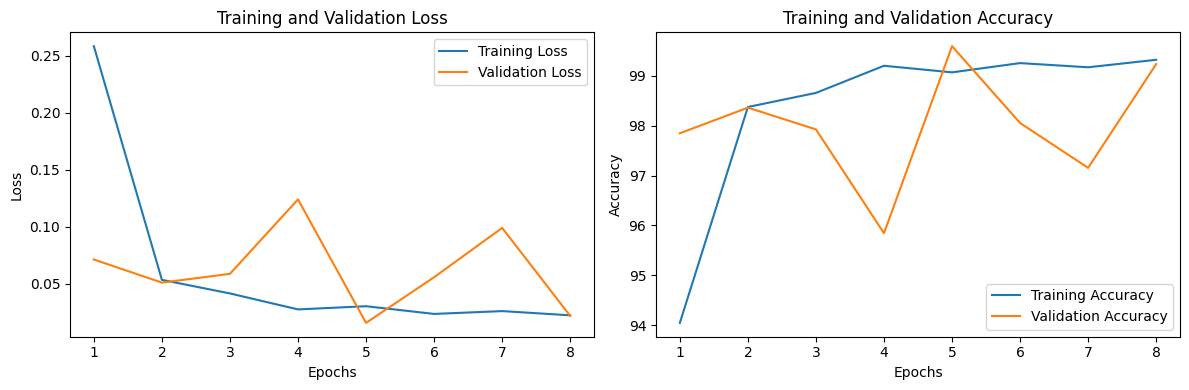

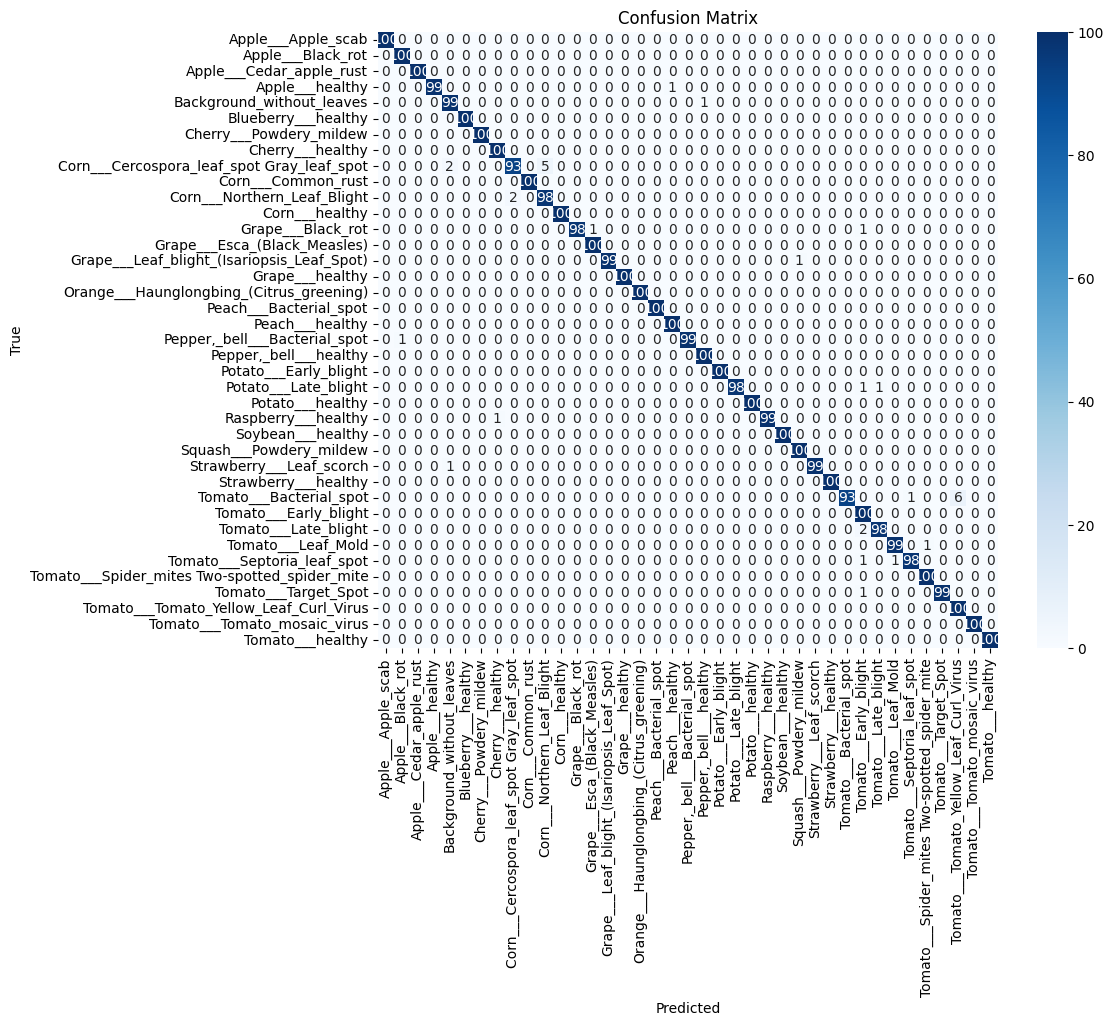

In [19]:
# Plot metrics and confusion matrix
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(all_labels, all_predictions, train_data.classes)

In [20]:
# Save the model, optimizer, and other components
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_transforms': train_transforms,
    'val_transforms': val_transforms,
    'test_transforms': test_transforms,
    'class_to_idx': train_data.class_to_idx,
    'num_classes': num_classes
}
torch.save(checkpoint, '/content/drive/My Drive/model_pth/PlantVillage_CNN_checkpoint_MobileVit_V2.pth')